## Import dependencies

In [1]:
from calendar import monthrange
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder

## Load training data frame

In [2]:
df_train = pd.read_excel("data/Vehicles_export_prices_scaled_train_eng.xlsx")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99071 entries, 0 to 99070
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(42), object(59)
memory usage: 80.1+ MB


In [4]:
df_train.head()

,RPAKREP_VEHICLE_HKEY,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,...,CUSTOMER_SALE_GROUP_NAME,CUSTOMER_SALE_GROUP2,CUSTOMER_SALE_GROUP2_NAME,SCALED_CURRENT_VALUE,SCALED_INVENTURAL_VALUE,SCALED_REPORT_VALUE,SCALED_VALUATION_PRICE,SCALED_GUIDE_PRICE,SCALED_TOTAL_SALES_PRICE_BASIS,SCALED_TOTAL_SALE_PRICE
0,77c1af48604226d47b2ccf7be44df009,44.0,TA,TOY,WF01XXERK1JR43779,FOR,Ford,ECS,ECOSPORT 1.0 Titanium Eco,NaN,...,EV privat,EVPR,Endverbraucher private,0.052907,0.000000,0.950043,0.0,0.002975,0.011018,0.011321
1,39587e4f9324333232d2ffaa2f314e6d,12.0,44,VOL,YV1XZK7V5S2487523,VOL,Volvo,XC4,"XC40 B3 B DKG Core 120 kW, 5-t",536K7170F1,...,NaN,NaN,NaN,0.061605,0.000000,0.950043,0.0,0.006136,0.026411,0.019844
2,a91470879cf756368c1d0099a2fa939a,27.0,33,SKO,WF0DXXSK0RX009819,FOR,Ford,TOC,Tourneo Connect 2.0 EcoBl,26,...,EV privat,EVPR,Endverbraucher private,0.063286,0.000000,0.950043,0.0,0.001378,0.022102,0.022053
3,61363a68ff967e7f0c4b80b46a55b141,33.0,K1,V,WVWZZZAWZPU075160,V,Volkswagen,POL,"POLO LIFE 1,0 L 59 KW (80 PS)",AE13GV,...,Interne Kunden,INT,Interne Kunden,0.042565,0.029537,0.897257,0.0,0.001378,0.000000,0.000572
4,fd5b09f7d857904d03a36d1a479f2ca4,10.0,96,FOR,WF0PXXGCHPRC20073,FOR,Ford,FOC,FOCUS TITA 5W 1.0T 125 MHEV M6,15,...,NaN,NaN,NaN,0.054914,0.000000,0.950043,0.0,0.004863,0.019715,0.013360


## Data frame preparation

### Manual dtype correction

In [5]:
dtypes = {
    "date": "datetime64[ns]",
    "num": np.float64,
    "str": pd.StringDtype(),
}

columns_of_interest = {
    "RPAKREP_VEHICLE_HKEY": "str",
    "COMPANY": "str",
    "OFFICE": "str",
    "OFFICE_MAIN_BRAND": "str",
    "CHASSIS_NUMBER": "str",
    "MANUFACTURER_SHORT": "str",
    "MANUFACTURER": "str",
    "VEHICLE_GROUP": "str",
    "VEHICLE_TYPE": "str",
    "MODEL_CODE": "str",
    "VARIANT": "str",
    "MILEAGE": "num",
    "OPERATING_HOURS": "num",
    "MILAGE_IN_FIELD": "num",
    "MILAGE_SALES": "num",
    "OPERATING_HOURS_SALES": "num",
    "RIM_KEY": "str",
    "COLOR_CODE": "str",
    "COLOR_CODE_NAME": "str",
    "COLOR": "str",
    "COLOR_TYPE": "str",
    "UPHOLSTERY_CODE": "str",
    "UPHOLSTERY": "str",
    "UPHOLSTERY_CODE_ALT": "str",
    "CERTIFICATE_TYPE": "str",
    "CERTIFICATE_TYPE_DATE": "num",
    "FACTORY_NUMBER": "str",
    "ENGINE_ID": "str",
    "ENGINE_TYPE": "str",
    "ENGINE_ID_ALT": "str",
    "TRANSMISSION": "str",
    "TRANSMISSION_TYPE": "str",
    "TRANSMISSION_ID": "str",
    "TRANSMISSION_SHORT": "str",
    "TRANSMISSION_NAME": "str",
    "RIMS": "str",
    "FRONT_TIRES": "str",
    "FRONT_TIRES_CONDITION": "num",
    "REAR_TIRES": "str",
    "REAR_TIRES_CONDITION": "num",
    "NUMBER_DOORS": "num",
    "NUMBER_SEATS": "num",
    "PERMITTED_TOTAL_WEIGHT": "num",
    "MAX_TRAILOR_LOAD": "num",
    "CURB_WEIGHT": "num",
    "YEAR_CONSTRUCTION": "num",
    "CONSTRUCTION_MONTH": "num",
    "NUMBER_AXLE": "num",
    "NUMBER_ENGINE_CYLINDER": "num",
    "REPAIR_RKZ": "num",
    "OPTICAL_CONDITION": "num",
    "TECHNICAL_CONDITION": "num",
    "ACCIDENT_VEHICLE": "str",
    "COMMISSION_NUMBER": "str",
    "HORSEPOWER": "num",
    "KW": "num",
    "CCM": "num",
    "NUMBER_OWNERS": "num",
    "IS_USED_CAR": "num",
    "LEASING_CONTRACT_DATE": "date",
    "LEASING_START": "date",
    "LEASING_END": "date",
    "LEASING_MILAGE": "num",
    "PAINT_TYPE": "str",
    "FINANCING_TYPE": "str",
    "FINANCING_TYPE_NAME": "str",
    "KAT_VEHICLE": "str",
    "FUEL_TYPE": "str",
    "FUEL_TYPE_NAME": "str",
    "DRIVE_TYPE": "str",
    "DRIVE_TYPE_NAME": "str",
    "VEHICLE_MODEL_ID": "str",
    "VEHICLE_MODEL_ID_NAME": "str",
    "COMMISSION_TYPE": "str",
    "COMMISSION_TYPE_NAME": "str",
    "DEMONSTRATION_STATUS": "str",
    "PURCHASE_DATE": "date",
    "PURCHASE_BOOKING_DATE": "date",
    "PURCHASE_MILAGE": "num",
    "PURCHASE_OPERATION_HOURS": "num",
    "PRICE_LIST": "str",
    "DAY_OF_REGISTRATION": "str",
    "AT_LOCATION_SINCE": "num",
    "LAID_UP_TIME": "num",
    "SOLD_CUSTOMER_ID": "str",
    "SOLD_INVOICE_COSTUMER_ID": "str",
    "MILAGE_SALE": "num",
    "OPERATION_HOURS_SALE": "num",
    "SOLD_INVOICE_COSTUMER_ID2": "str",
    "CUSTOMER_TYPE": "str",
    "CUSTOMER_GROUP": "str",
    "CUSTOMER_GROUP_NAME": "str",
    "CUSTOMER_FEATURE": "str",
    "CUSTOMER_FEATURE_NAME": "str",
    "SALE_CUSTOMER_ID2": "str",
    "CUSTOMER_SALE_GROUP": "str",
    "CUSTOMER_SALE_GROUP_NAME": "str",
    "CUSTOMER_SALE_GROUP2": "str",
    "CUSTOMER_SALE_GROUP2_NAME": "str",
    "SCALED_CURRENT_VALUE": "num",
    "SCALED_INVENTURAL_VALUE": "num",
    "SCALED_REPORT_VALUE": "num",
    "SCALED_VALUATION_PRICE": "num",
    "SCALED_GUIDE_PRICE": "num",
    "SCALED_TOTAL_SALES_PRICE_BASIS": "num",
    "SCALED_TOTAL_SALE_PRICE": "num",
}


def correct_df_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    return df[columns_of_interest.keys()]\
        .astype({k: dtypes[v] for k, v in columns_of_interest.items()})

### Add custom features

In [6]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]


def create_date(year, month=1, day=1):
    if math.isnan(year) or math.isnan(month) or math.isnan(day):
        return pd.NaT
    if year < 1900:
        return pd.NaT
    return datetime.datetime(int(year), int(month), int(day))


def month_idx_to_name(month_idx):
    if math.isnan(month_idx):
        return pd.NA
    return months[int(month_idx - 1)]


def day_idx_to_name(day_idx):
    if math.isnan(day_idx):
        return pd.NA
    return int(day_idx)


def weekday_idx_to_name(weekday_idx):
    if math.isnan(weekday_idx):
        return pd.NA
    return days[int(weekday_idx)]


def add_custom_features(df: pd.DataFrame) -> pd.DataFrame:
    df_feat = df.copy()
    
    # Compare OFFICE_MAIN_BRAND and MANUFACTURER_SHORT
    df_feat["COMP__OFFICE_MAIN_BRAND__MANUFACTURER_SHORT"] = \
        (df_feat["OFFICE_MAIN_BRAND"] == df_feat["MANUFACTURER_SHORT"])\
        .astype(dtypes["num"])

    # Construct datetime from YEAR_CONSTRUCTION and CONSTRUCTION_MONTH
    df_feat["CONSTRUCTION_DATE"] = df_feat[["YEAR_CONSTRUCTION", "CONSTRUCTION_MONTH"]]\
        .apply(lambda x: create_date(year=x["YEAR_CONSTRUCTION"], month=x["CONSTRUCTION_MONTH"]), axis=1)\
        .astype(dtypes["date"])

    # Separate year, month, day, weekday for dates
    for col in df_feat.select_dtypes(include=dtypes["date"]).columns:
        df_feat[f"{col}__YEAR"] = df_feat[col].map(lambda date: date.year)\
            .astype(dtypes["num"])

        df_feat[f"{col}__MONTH"] = df_feat[col].map(lambda date: month_idx_to_name(date.month))\
            .astype(dtypes["str"])

        df_feat[f"{col}__DAY"] = df_feat[col].map(lambda date: day_idx_to_name(date.day))\
            .astype(dtypes["str"])
        
        df_feat[f"{col}__WEEKDAY"] = df_feat[col].map(lambda date: weekday_idx_to_name(date.weekday()))\
            .astype(dtypes["str"])
    
    # Time span between different date features
    date_cols = df_feat.select_dtypes(include=dtypes["date"]).columns
    for date_col_idx_a in range(len(date_cols)):
        for date_col_idx_b in range(date_col_idx_a + 1, len(date_cols)):
            date_col_a = date_cols[date_col_idx_a]
            date_col_b = date_cols[date_col_idx_b]
            df_feat[f"DIFF__{date_col_a}__{date_col_b}"] = \
                (df_feat[date_col_a] - df_feat[date_col_b])\
                .map(lambda diff: diff.days)\
                .astype(dtypes["num"])
    
    return df_feat

### Split data frame into features and labels

In [7]:
def split_data_frame(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    # Features
    X = df.drop("LAID_UP_TIME", axis=1)

    # Labels
    y = df["LAID_UP_TIME"]

    return X, y

### Preperation function

In [71]:
def prepare_data_frame(df: pd.DataFrame, is_training_data: bool) -> pd.DataFrame:
    df_prep = df.copy()

    # YEAR_CONSTRUCTION Fix
    df_prep["YEAR_CONSTRUCTION"] = df_prep["YEAR_CONSTRUCTION"].map(lambda x: x if type(x) == float else np.nan)
    
    # Manual dtype correction
    df_prep = correct_df_dtypes(df_prep)

    # Keep only unique rows
    df_prep = df_prep.drop_duplicates()

    # Drop train samples without label value
    if is_training_data:
        df_prep = df_prep.dropna(subset=["LAID_UP_TIME"])
    
    # Add custom features
    df_prep = add_custom_features(df_prep)

    return df_prep

### Prepare training data

In [72]:
df_train_prep = prepare_data_frame(df_train, is_training_data=True)

In [10]:
df_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98821 entries, 0 to 99070
Columns: 147 entries, RPAKREP_VEHICLE_HKEY to DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
dtypes: datetime64[ns](6), float64(61), string(80)
memory usage: 111.6 MB


In [69]:
df_train_prep.head()

,RPAKREP_VEHICLE_HKEY,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,...,DIFF__LEASING_START__LEASING_END,DIFF__LEASING_START__PURCHASE_DATE,DIFF__LEASING_START__PURCHASE_BOOKING_DATE,DIFF__LEASING_START__CONSTRUCTION_DATE,DIFF__LEASING_END__PURCHASE_DATE,DIFF__LEASING_END__PURCHASE_BOOKING_DATE,DIFF__LEASING_END__CONSTRUCTION_DATE,DIFF__PURCHASE_DATE__PURCHASE_BOOKING_DATE,DIFF__PURCHASE_DATE__CONSTRUCTION_DATE,DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
0,77c1af48604226d47b2ccf7be44df009,44.0,TA,TOY,WF01XXERK1JR43779,FOR,Ford,ECS,ECOSPORT 1.0 Titanium Eco,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1977.0,1977.0
1,39587e4f9324333232d2ffaa2f314e6d,12.0,44,VOL,YV1XZK7V5S2487523,VOL,Volvo,XC4,"XC40 B3 B DKG Core 120 kW, 5-t",536K7170F1,...,-364.0,22.0,21.0,-341.0,386.0,385.0,23.0,-1.0,-363.0,-362.0
2,a91470879cf756368c1d0099a2fa939a,27.0,33,SKO,WF0DXXSK0RX009819,FOR,Ford,TOC,Tourneo Connect 2.0 EcoBl,26,...,-1643.0,13.0,13.0,NaN,1656.0,1656.0,NaN,0.0,NaN,NaN
3,61363a68ff967e7f0c4b80b46a55b141,33.0,K1,V,WVWZZZAWZPU075160,V,Volkswagen,POL,"POLO LIFE 1,0 L 59 KW (80 PS)",AE13GV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,fd5b09f7d857904d03a36d1a479f2ca4,10.0,96,FOR,WF0PXXGCHPRC20073,FOR,Ford,FOC,FOCUS TITA 5W 1.0T 125 MHEV M6,15,...,-373.0,56.0,42.0,82.0,429.0,415.0,455.0,-14.0,26.0,40.0


## Inspect features

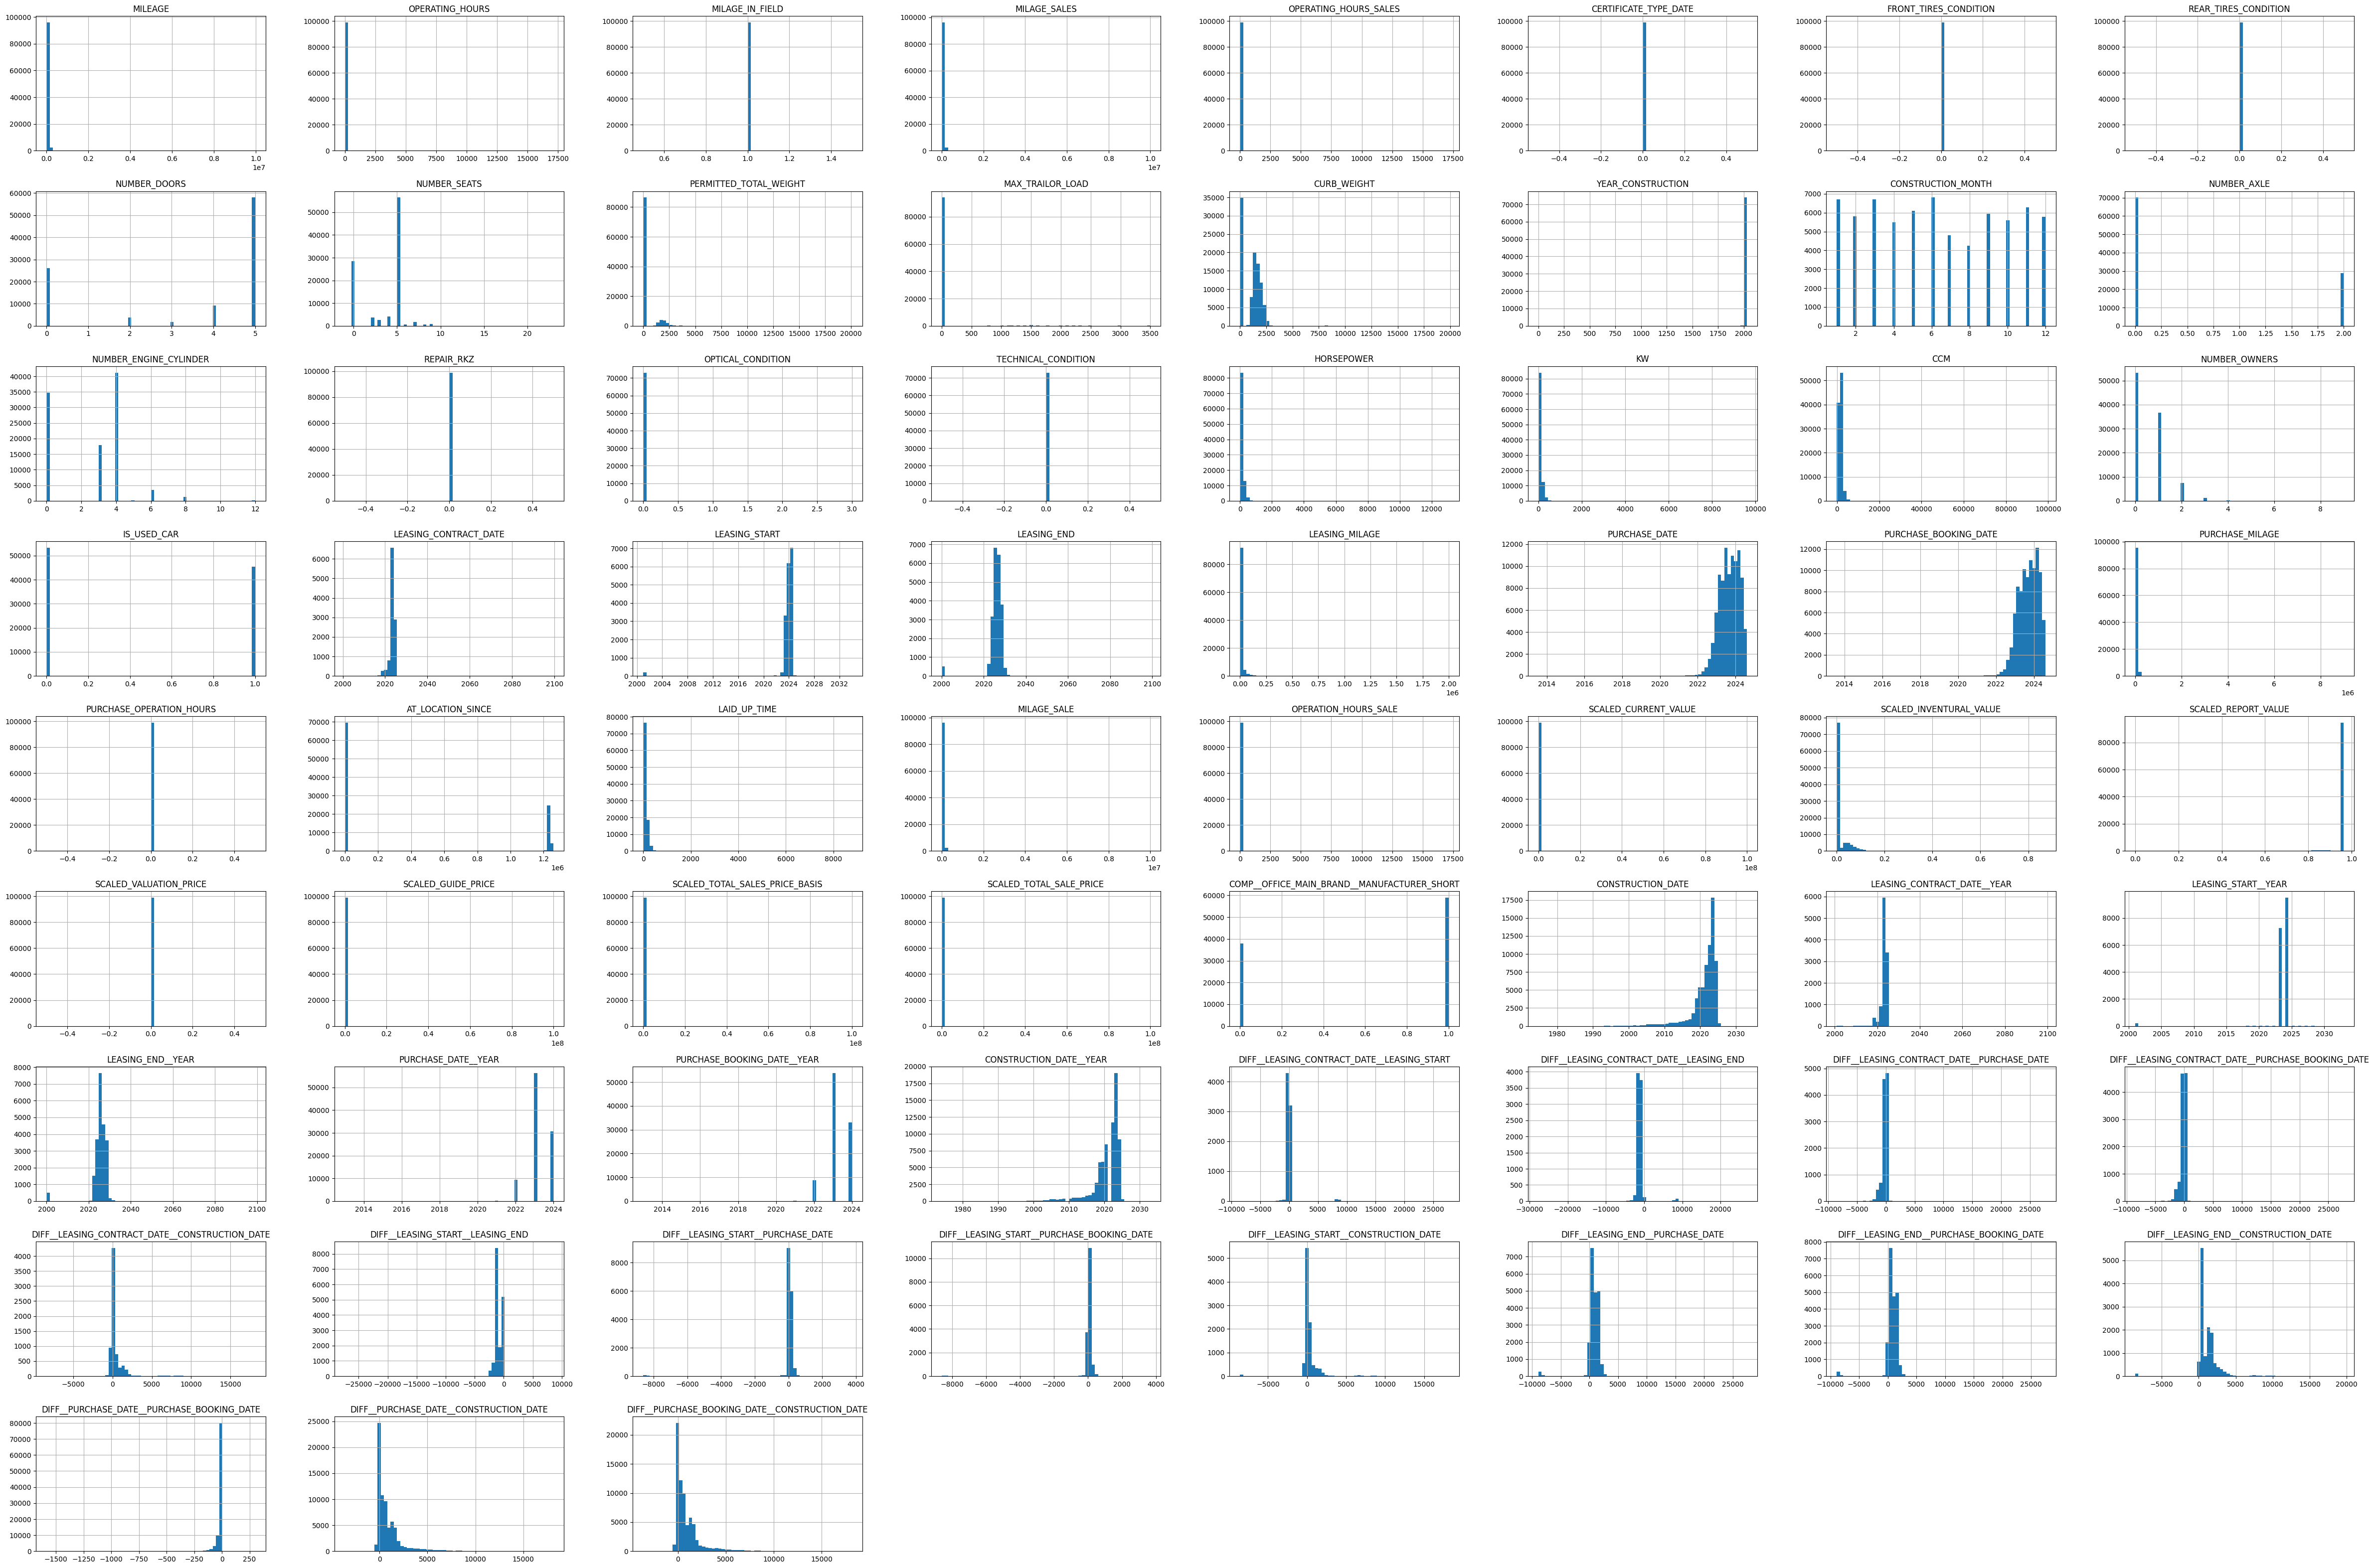

In [12]:
df_train_prep.hist(bins=64, figsize=(60, 40))
plt.show()

In [13]:
corr_matrix = df_train_prep.select_dtypes(include=dtypes["num"]).corr()
print(corr_matrix["LAID_UP_TIME"][corr_matrix["LAID_UP_TIME"].notna()].sort_values(ascending=False))

LAID_UP_TIME                                          1.000000
SCALED_INVENTURAL_VALUE                               0.309403
DIFF__LEASING_START__PURCHASE_DATE                    0.189873
DIFF__LEASING_START__PURCHASE_BOOKING_DATE            0.170430
DIFF__LEASING_END__PURCHASE_DATE                      0.135625
DIFF__LEASING_END__PURCHASE_BOOKING_DATE              0.125470
CONSTRUCTION_DATE__YEAR                               0.100818
DIFF__LEASING_CONTRACT_DATE__PURCHASE_DATE            0.097761
LEASING_START__YEAR                                   0.096605
DIFF__LEASING_CONTRACT_DATE__PURCHASE_BOOKING_DATE    0.093390
LEASING_END__YEAR                                     0.091454
AT_LOCATION_SINCE                                     0.088012
DIFF__LEASING_START__LEASING_END                      0.087107
NUMBER_AXLE                                           0.061946
IS_USED_CAR                                           0.049001
CURB_WEIGHT                                           0

## Split test and train set

In [14]:
df_train_train, df_train_test = train_test_split(df_train_prep, test_size=0.2, random_state=0)

In [15]:
X, y = split_data_frame(df_train_prep)
X_train, y_train = split_data_frame(df_train_train)
X_test, y_test = split_data_frame(df_train_test)

mean: 88.56825541388383
std: 104.83340619388476


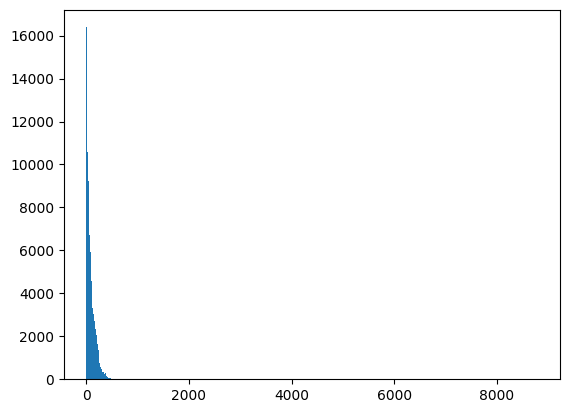

In [16]:
print(f"mean: {np.mean(y_train)}")
print(f"std: {np.std(y_train)}")
plt.hist(y_train, bins=512)
plt.show()

## Preprocessing

In [40]:
def map_date(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.map(lambda date: date_to_number(date))


def date_to_number(date: np.datetime64) -> np.float64:
    if date is pd.NaT:
        return np.nan
    return date.year + date.month / 12.0 + date.day / (12.0 * monthrange(date.year, date.month)[1])


def map_to_nan(feature: pd.DataFrame, values: list):
    return feature.map(lambda x: np.nan if x in values else x)


def create_preprocessor(
    keep_dates: bool = True,
    keep_nums: bool = True,
    keep_strs: bool = True,
) -> Pipeline:
    date_transformer = Pipeline([
        ("converter", FunctionTransformer(map_date)),
        ("imputer", SimpleImputer()),
        ("scaler", RobustScaler()),
    ])

    num_transformer = Pipeline([
        ("per_feature", ColumnTransformer([
            ("PERMITTED_TOTAL_WEIGHT", FunctionTransformer(lambda x: map_to_nan(x, [0.0])), ["PERMITTED_TOTAL_WEIGHT"]),
            ("CURB_WEIGHT", FunctionTransformer(lambda x: map_to_nan(x, [0.0])), ["CURB_WEIGHT"]),
            ("HORSEPOWER", FunctionTransformer(lambda x: map_to_nan(x, [0.0])), ["HORSEPOWER"]),
            ("KW", FunctionTransformer(lambda x: map_to_nan(x, [0.0])), ["KW"]),
            ("CCM", FunctionTransformer(lambda x: map_to_nan(x, [0.0])), ["CCM"]),
            ("SCALED_INVENTURAL_VALUE", FunctionTransformer(lambda x: map_to_nan(x, [0.0])), ["SCALED_INVENTURAL_VALUE"]),
        ], remainder="passthrough", verbose_feature_names_out=False)),
        ("imputer", SimpleImputer()),
        ("scaler", RobustScaler()),
    ])

    str_transformer = Pipeline([
        ("imputer", SimpleImputer(missing_values=pd.NA, strategy="constant", keep_empty_features=True, fill_value="N/A")),
        ("encoder", OneHotEncoder(min_frequency=0.01, handle_unknown="infrequent_if_exist", sparse_output=False)),
    ])

    per_dtype_transformers = []
    if keep_dates:
        per_dtype_transformers.append(\
            ("date", date_transformer, make_column_selector(dtype_include=dtypes["date"])))
    if keep_nums:
        per_dtype_transformers.append(\
            ("num", num_transformer, make_column_selector(dtype_include=dtypes["num"])))
    if keep_strs:
        per_dtype_transformers.append(\
            ("str", str_transformer, make_column_selector(dtype_include=dtypes["str"])))
    
    return Pipeline(
        [
            ("per_dtype", ColumnTransformer(per_dtype_transformers)),
            ("variance_threshold", VarianceThreshold()),
        ]
    )

### Inspect preprocessing pipeline

In [59]:
create_preprocessor()

Pipeline(steps=[('per_dtype',
                 ColumnTransformer(transformers=[('date',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function map_date at 0x0000021F88930900>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021F84B5EF90>),
                                                 ('num',
                                                  Pipeline(steps=[('per_feature',
                                                                   Column...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 keep_empty_features=True,
                                                                                 missing_values=<NA>,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.01,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021F84B90890>)])),
                ('variance_threshold', VarianceThreshold())])

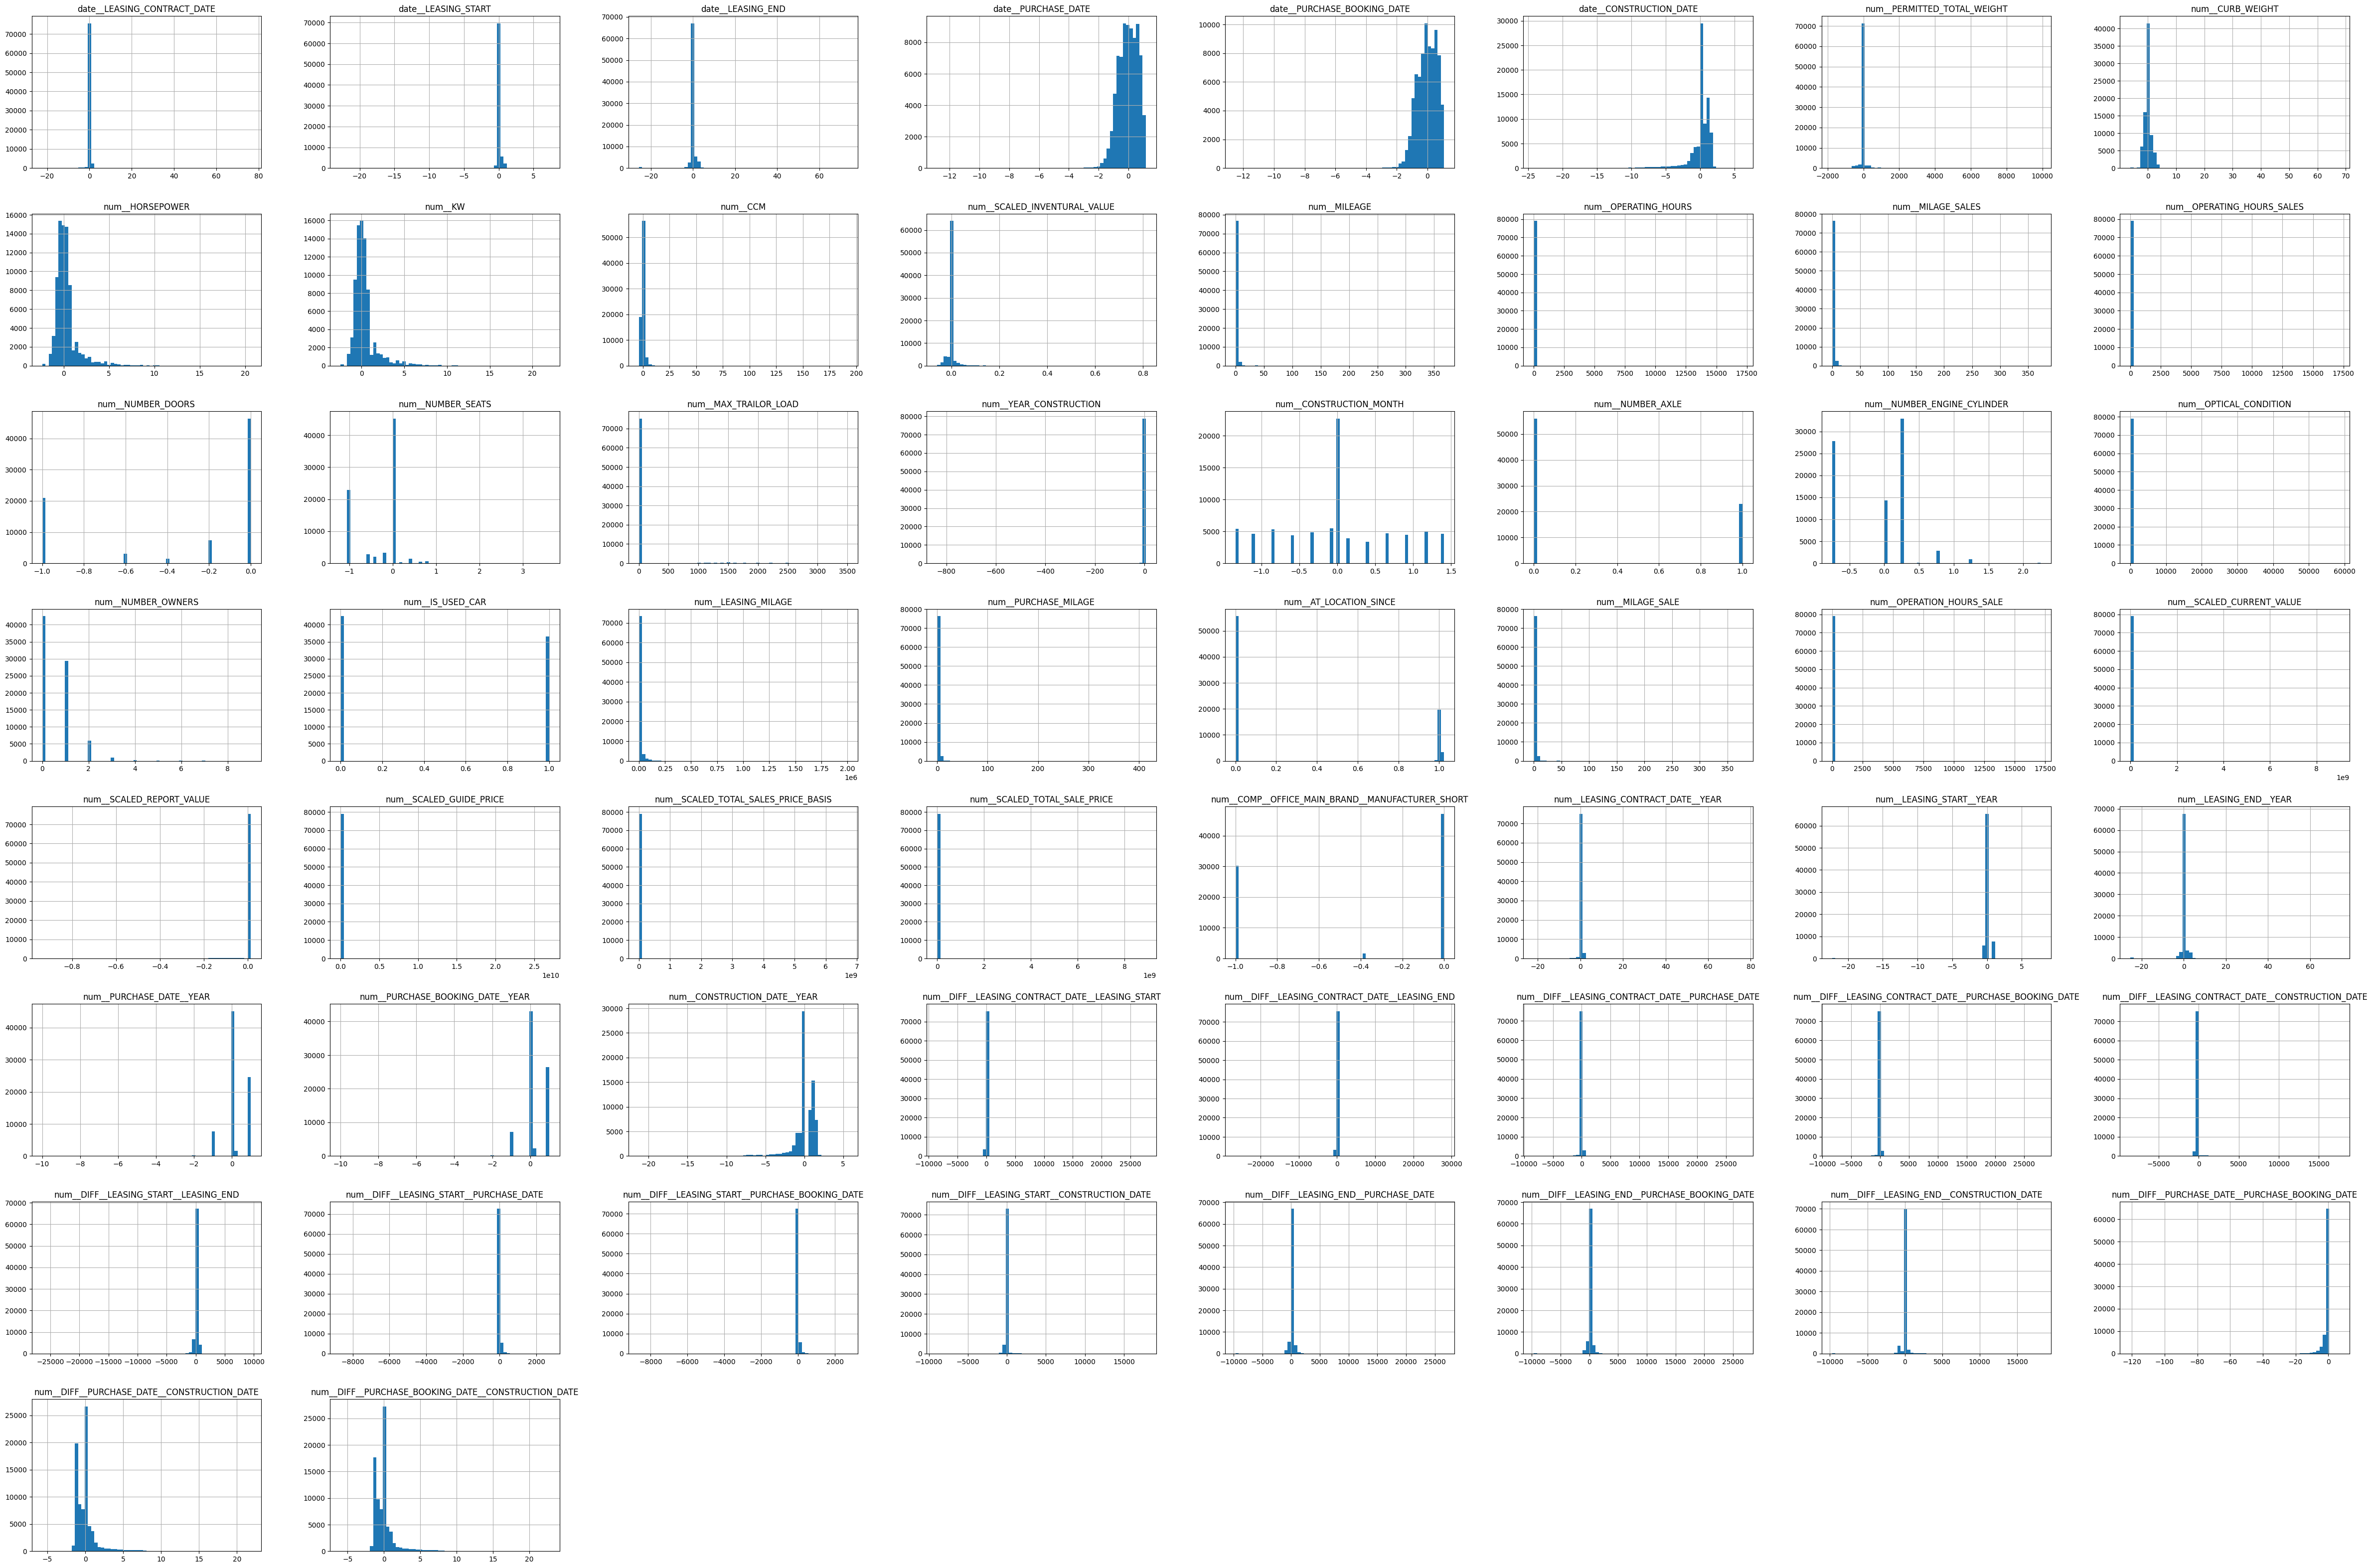

In [41]:
preprocessor = create_preprocessor(keep_strs=False)
preprocessor.set_output(transform="pandas")
X_prep: pd.DataFrame = preprocessor.fit_transform(X_train, y_train)
X_prep.hist(bins=64, figsize=(60, 40))
plt.show()

## Model selection

### Helper functions

In [42]:
def validate_model(model: BaseEstimator):
    X_val_train, X_val, y_val_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12) 
    model.fit(X_val_train, y_val_train)
    y_pred = model.predict(X_val)
    print("RMSE:", root_mean_squared_error(y_val, y_pred))

In [43]:
def cross_validate_model(model: BaseEstimator):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("RMSE Std:", rmse_scores.std())

In [44]:
def test_model(model: BaseEstimator):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("RMSE:", root_mean_squared_error(y_test, y_pred))

### Linear Regression

In [75]:
linear_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectPercentile(f_regression, percentile=10)),
    ("regressor", LinearRegression(n_jobs=-1)),
])
cross_validate_model(linear_reg)

RMSE Scores: [73.10900558 70.60845494 98.64297327 69.76238367 95.73503278]
RMSE Mean: 81.57157004587211
RMSE Std: 12.83197769442864


### Random Forest Regressor

In [46]:
rng = np.random.RandomState(42)
rand_forest_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectPercentile(f_regression, percentile=10)),
    ("regressor", RandomForestRegressor(n_jobs=-1, random_state=rng)),
])
cross_validate_model(rand_forest_reg)

RMSE Scores: [58.16767104 69.77651136 87.92395167 52.28378882 85.51904584]
RMSE Mean: 70.73419374701159
RMSE Std: 14.236093000078782


### Histogram-Based Gradient Boosting Regressor

In [47]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", HistGradientBoostingRegressor(random_state=rng)),
])
cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [47.44722999 45.82586763 83.51464804 44.8425398  78.31375962]
RMSE Mean: 59.988809017296944
RMSE Std: 17.18463558557093


### Select final model

In [48]:
final_model = hist_grad_boost_reg

## Evaluate model on the test set

In [49]:
test_model(final_model)

RMSE: 45.81816743472213


## Train final model on the full data set

In [58]:
final_model.fit(X, y);

## Load test data frame

In [51]:
df_new = pd.read_excel("data/Vehicles_export_prices_scaled_stud_test_eng.xlsx")

In [52]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42460 entries, 0 to 42459
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(41), object(60)
memory usage: 34.3+ MB


In [73]:
df_new_prep = prepare_data_frame(df_new, is_training_data=False)

In [54]:
df_new_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42416 entries, 0 to 42459
Columns: 147 entries, RPAKREP_VEHICLE_HKEY to DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
dtypes: datetime64[ns](6), float64(61), string(80)
memory usage: 47.9 MB


## Predict test data values

In [55]:
X_new, _ = split_data_frame(df_new_prep)
y_new = final_model.predict(X_new)

## Save predicted test data values

In [56]:
def save_to_xlsx(features: pd.DataFrame, predictions: np.array, filename: str):
    output_dir = "predictions"
    os.makedirs(output_dir, exist_ok=True)
    
    df_output = features.copy()
    df_output["LAID_UP_TIME"] = predictions
    df_output[["CHASSIS_NUMBER", "LAID_UP_TIME"]].to_excel(f"{output_dir}/{filename}", index = False)

In [57]:
save_to_xlsx(X_new, y_new, "teamA-model0.xlsx")

Next steps:
- better feature selection (e.g. PCA)
- GridSearch
- Round predictions
- outlier detection
- per feature mapping (to nulls, etc.)